In [1]:
import mdtraj as md
from ase import Atoms
import nglview as nv
import networkx as nx
import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# loading the xtc and gro file into mdtraj
traj = md.load('../../../xtc_files/50000eql2.xtc', top='../../../xtc_files/conf.gro')

In [3]:
# converting traj as traj with only 5000 frames
traj=traj[::10]

In [4]:
# creating the frame feature matrix
nframes = traj.xyz.shape[0]
natoms=traj.topology.residue(0).n_atoms
nmols=traj.topology.n_residues
frame_feature=[]
for i in tqdm(range(nframes)):
    com_pos=[] # position of Center of Mass of each molecule
    for res in range(nmols):
        com_pos.append(traj.xyz[i][res*natoms:(res+1)*natoms].mean(axis=0))
    frame_feature.append(com_pos)
frame_feature=np.array(frame_feature)
print(frame_feature.shape)

100%|██████████| 5001/5001 [00:11<00:00, 439.66it/s]


(5001, 592, 3)


In [5]:
# creating the edge index matrix
cutoff=0.5
all_edge_list=[]
for i in tqdm(range(nframes)):
    fromlist=[]
    tolist=[]
    for j in range(nmols):
        for k in range(j+1,nmols):
            if np.linalg.norm(frame_feature[i][j]-frame_feature[i][k])<cutoff:
                fromlist.append(j)
                tolist.append(k)
                tolist.append(j)
                fromlist.append(k)
    edgelist=np.array([fromlist,tolist]).astype(np.int64)
    all_edge_list.append(edgelist)
print(len(all_edge_list))

  4%|▎         | 187/5001 [01:18<1:34:17,  1.18s/it]

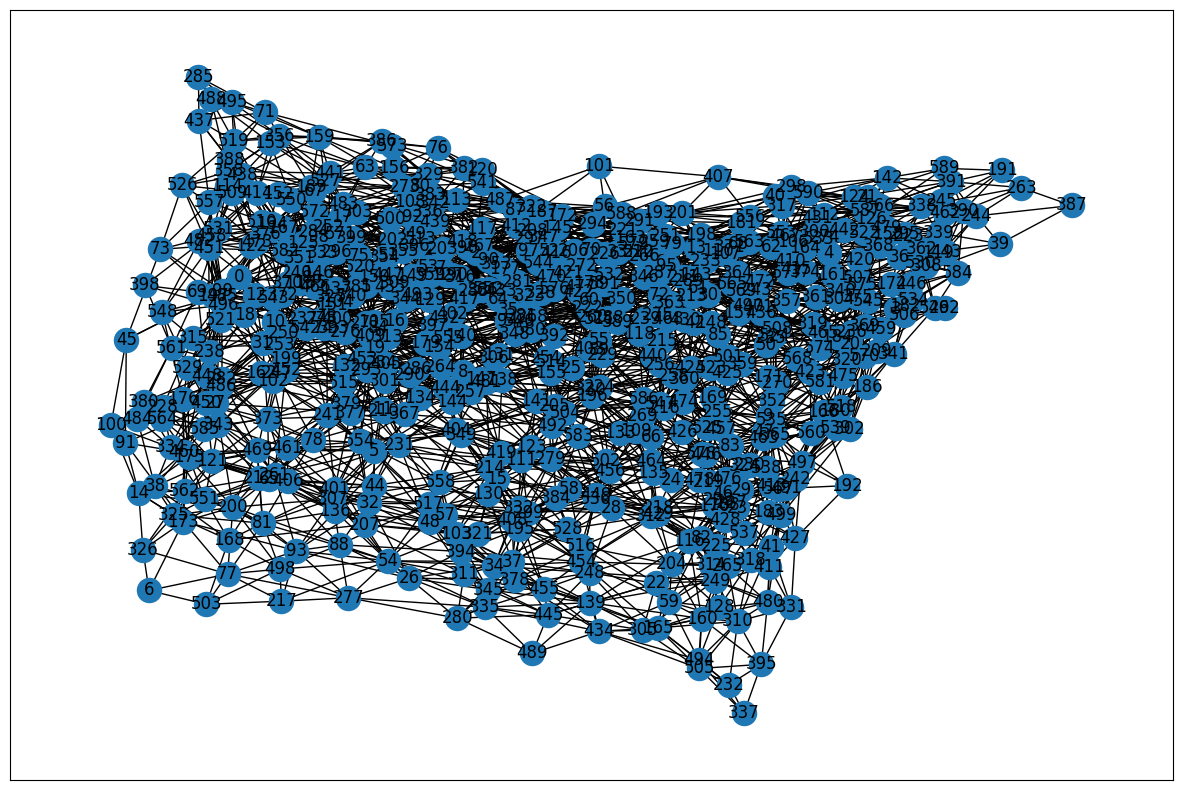

In [ ]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index
frame = 10
plt.figure(figsize=(15,10))
adj_binary = convert_to_adj(all_edge_list[frame], num_nodes=592)
indices = torch.where(adj_binary)
G = nx.Graph()
edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
G.add_edges_from(edges)
nx.draw_networkx(G)

In [ ]:
graphs = []
for frame in tqdm(range(nframes)):
    g = data.Data(x=torch.tensor(frame_feature[frame]).float(), edge_index=torch.tensor(all_edge_list[frame]).long(), y=torch.tensor([0]))
    graphs.append(g)

print(graphs[0])

100%|██████████| 5001/5001 [00:00<00:00, 5357.33it/s]

Data(x=[592, 3], edge_index=[2, 8126], y=[1])


In [ ]:
# import model.
from model import *

In [ ]:
input_dim = graphs[0].num_features
output_dim = 2
lr=1e-4
epochs=100
batch_size=1
model=VGAE(VariationalGCNEncoder(input_dim, output_dim),
           VariationalGCNDecoder(output_dim,input_dim))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
from pytorch3d.loss import chamfer_distance

In [ ]:
train_loader_set = DataLoader(graphs[:int(nframes*0.6)], batch_size=batch_size, shuffle=True)
validation_loader_set = DataLoader(graphs[int(nframes*0.6):int(nframes*0.8)], batch_size=batch_size, shuffle=True)
test_loader_set = DataLoader(graphs[int(nframes*0.8):], batch_size=batch_size, shuffle=True)

In [ ]:
#for data in train_loader_set:
#    z,encoded_edgeindex=model.encode(data.x,data.edge_index)
#    decodedx,decoded_edgeindex=model.decode(z,encoded_edgeindex)
#    # print(data)
#    print(decodedx)
#    print("data.x")
#    print(data.x)
#    print("sizes")
#    print(decodedx.size())
#    print(data.x.size())

In [ ]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in train_loader_set:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss 
        loss = FeatureLoss + EdgeLoss + closs
        loss = loss 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

        loss.backward()
        optimizer.step()

        

    return loss_all / len(train_loader_set.dataset),closs_all/len(train_loader_set.dataset), feature_loss_all / len(train_loader_set.dataset), edge_loss_all / len(train_loader_set.dataset), kl_loss_all / len(train_loader_set.dataset)

In [ ]:
# writing a vakidation function
def validate():
    model.eval()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in validation_loader_set:
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss 
        loss = FeatureLoss + EdgeLoss + closs
        loss = loss 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

    return loss_all / len(validation_loader_set.dataset),closs_all/len(validation_loader_set.dataset), feature_loss_all / len(validation_loader_set.dataset), edge_loss_all / len(validation_loader_set.dataset), kl_loss_all / len(validation_loader_set.dataset)

In [ ]:
lossFxn = torch.nn.MSELoss()
def test():
    model.eval()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    type_loss_all = 0
    closs_all=0
    for data in test_loader_set:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index= model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        loss = FeatureLoss + EdgeLoss+closs 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        

    return loss_all / len(test_loader_set.dataset), closs_all/len(test_loader_set.dataset),feature_loss_all / len(test_loader_set.dataset), edge_loss_all / len(test_loader_set.dataset), kl_loss_all / len(test_loader_set.dataset)

In [ ]:
total_losses = []
feature_losses = []
edge_losses = []
kl_losses = []
val_total_losses = []
val_feature_losses = []
val_edge_losses = []
val_kl_losses = []
test_total_losses = []
test_feature_losses = []
test_edge_losses = []
test_kl_losses = []
cd_losses=[]
val_cd_losses=[]
test_cd_losses=[]
for epoch in tqdm(range(1, epochs+ 1)):
    total_loss, cd_loss,feature_loss, edge_loss, kl_loss = train()
    val_total_loss, val_cd_loss,val_feature_loss, val_edge_loss, val_kl_loss = validate()
    test_total_loss, test_cd_loss,test_feature_loss, test_edge_loss, test_kl_loss = test()
    print(f'Epoch: {epoch:03d}')
    print(f'TRAIN : Total Loss: {total_loss:.4f}, CD Loss : {cd_loss:.4f}, Feature Loss: {feature_loss:.4f}, Edge Loss: {edge_loss:.4f}')
    print(f'VALIDATE : Total Loss: {val_total_loss:.4f}, CD Loss : {val_cd_loss:.4f},Feature Loss: {val_feature_loss:.4f}, Edge Loss: {val_edge_loss:.4f}')
    print(f'TEST : Total Loss: {test_total_loss:.4f},CD Loss : {test_cd_loss:.4f}, Feature Loss: {test_feature_loss:.4f}, Edge Loss: {test_edge_loss:.4f}')
    total_losses.append(total_loss)
    feature_losses.append(feature_loss)
    edge_losses.append(edge_loss)
    kl_losses.append(kl_loss)
    val_total_losses.append(val_total_loss)
    val_feature_losses.append(val_feature_loss)
    val_edge_losses.append(val_edge_loss)
    val_kl_losses.append(val_kl_loss)
    test_total_losses.append(test_total_loss)
    test_feature_losses.append(test_feature_loss)
    test_edge_losses.append(test_edge_loss)
    test_kl_losses.append(test_kl_loss)
    cd_losses.append(cd_loss)
    val_cd_losses.append(val_cd_loss)   
    test_cd_losses.append(test_cd_loss) 
    

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_5990/1287167025.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
/tmp/ipykernel_5990/368484634.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
/tmp/ipykernel_5990/3817500453.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
  1%|          | 1/100 [12:03<19:54:31, 723.95s/it]

Epoch: 001
TRAIN : Total Loss: 3.2840, CD Loss : 2.3632, Feature Loss: 0.9209, Edge Loss: 0.0000
VALIDATE : Total Loss: 1.5089, CD Loss : 1.0833,Feature Loss: 0.4256, Edge Loss: 0.0000
TEST : Total Loss: 1.5098,CD Loss : 1.0842, Feature Loss: 0.4256, Edge Loss: 0.0000


  2%|▏         | 2/100 [15:02<10:58:26, 403.13s/it]

Epoch: 002
TRAIN : Total Loss: 1.1596, CD Loss : 0.7802, Feature Loss: 0.3795, Edge Loss: 0.0000
VALIDATE : Total Loss: 1.5675, CD Loss : 1.1160,Feature Loss: 0.4515, Edge Loss: 0.0000
TEST : Total Loss: 1.5680,CD Loss : 1.1166, Feature Loss: 0.4514, Edge Loss: 0.0000


  3%|▎         | 3/100 [21:47<10:53:21, 404.14s/it]

Epoch: 003
TRAIN : Total Loss: 1.0145, CD Loss : 0.6805, Feature Loss: 0.3340, Edge Loss: 0.0000
VALIDATE : Total Loss: 1.5679, CD Loss : 1.1316,Feature Loss: 0.4363, Edge Loss: 0.0000
TEST : Total Loss: 1.5684,CD Loss : 1.1323, Feature Loss: 0.4362, Edge Loss: 0.0000


  4%|▍         | 4/100 [22:29<6:57:23, 260.87s/it] 

Epoch: 004
TRAIN : Total Loss: 1.0341, CD Loss : 0.7090, Feature Loss: 0.3251, Edge Loss: 0.0000
VALIDATE : Total Loss: 1.5295, CD Loss : 1.1096,Feature Loss: 0.4199, Edge Loss: 0.0000
TEST : Total Loss: 1.5302,CD Loss : 1.1103, Feature Loss: 0.4198, Edge Loss: 0.0000


  5%|▌         | 5/100 [23:11<4:48:16, 182.07s/it]

Epoch: 005
TRAIN : Total Loss: 1.0322, CD Loss : 0.7143, Feature Loss: 0.3179, Edge Loss: 0.0000
VALIDATE : Total Loss: 1.4620, CD Loss : 1.0585,Feature Loss: 0.4034, Edge Loss: 0.0000
TEST : Total Loss: 1.4628,CD Loss : 1.0594, Feature Loss: 0.4033, Edge Loss: 0.0000


  6%|▌         | 6/100 [23:52<3:29:56, 134.01s/it]

Epoch: 006
TRAIN : Total Loss: 1.0140, CD Loss : 0.7034, Feature Loss: 0.3106, Edge Loss: 0.0000
VALIDATE : Total Loss: 1.3374, CD Loss : 0.9620,Feature Loss: 0.3753, Edge Loss: 0.0000
TEST : Total Loss: 1.3383,CD Loss : 0.9630, Feature Loss: 0.3753, Edge Loss: 0.0000


  7%|▋         | 7/100 [24:32<2:40:20, 103.44s/it]

Epoch: 007
TRAIN : Total Loss: 0.9946, CD Loss : 0.6911, Feature Loss: 0.3035, Edge Loss: 0.0000
VALIDATE : Total Loss: 1.1879, CD Loss : 0.8473,Feature Loss: 0.3406, Edge Loss: 0.0000
TEST : Total Loss: 1.1886,CD Loss : 0.8481, Feature Loss: 0.3405, Edge Loss: 0.0000


  8%|▊         | 8/100 [25:16<2:09:40, 84.57s/it] 

Epoch: 008
TRAIN : Total Loss: 0.9661, CD Loss : 0.6724, Feature Loss: 0.2937, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.9732, CD Loss : 0.6929,Feature Loss: 0.2804, Edge Loss: 0.0000
TEST : Total Loss: 0.9740,CD Loss : 0.6936, Feature Loss: 0.2804, Edge Loss: 0.0000


  9%|▉         | 9/100 [25:55<1:46:21, 70.13s/it]

Epoch: 009
TRAIN : Total Loss: 0.8926, CD Loss : 0.6288, Feature Loss: 0.2638, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.8263, CD Loss : 0.5959,Feature Loss: 0.2304, Edge Loss: 0.0000
TEST : Total Loss: 0.8271,CD Loss : 0.5968, Feature Loss: 0.2303, Edge Loss: 0.0000


 10%|█         | 10/100 [26:39<1:33:17, 62.20s/it]

Epoch: 010
TRAIN : Total Loss: 0.8087, CD Loss : 0.5817, Feature Loss: 0.2271, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.7898, CD Loss : 0.5684,Feature Loss: 0.2214, Edge Loss: 0.0000
TEST : Total Loss: 0.7905,CD Loss : 0.5691, Feature Loss: 0.2214, Edge Loss: 0.0000


 11%|█         | 11/100 [27:16<1:20:52, 54.53s/it]

Epoch: 011
TRAIN : Total Loss: 0.7606, CD Loss : 0.5455, Feature Loss: 0.2151, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.7132, CD Loss : 0.5077,Feature Loss: 0.2055, Edge Loss: 0.0000
TEST : Total Loss: 0.7136,CD Loss : 0.5081, Feature Loss: 0.2055, Edge Loss: 0.0000


 12%|█▏        | 12/100 [27:53<1:12:07, 49.17s/it]

Epoch: 012
TRAIN : Total Loss: 0.6553, CD Loss : 0.4581, Feature Loss: 0.1972, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.6113, CD Loss : 0.4202,Feature Loss: 0.1910, Edge Loss: 0.0000
TEST : Total Loss: 0.6115,CD Loss : 0.4205, Feature Loss: 0.1910, Edge Loss: 0.0000


 13%|█▎        | 13/100 [28:34<1:07:46, 46.74s/it]

Epoch: 013
TRAIN : Total Loss: 0.5839, CD Loss : 0.3962, Feature Loss: 0.1877, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.5597, CD Loss : 0.3757,Feature Loss: 0.1840, Edge Loss: 0.0000
TEST : Total Loss: 0.5602,CD Loss : 0.3761, Feature Loss: 0.1841, Edge Loss: 0.0000


 14%|█▍        | 14/100 [29:11<1:02:41, 43.74s/it]

Epoch: 014
TRAIN : Total Loss: 0.5374, CD Loss : 0.3565, Feature Loss: 0.1809, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.5154, CD Loss : 0.3380,Feature Loss: 0.1774, Edge Loss: 0.0000
TEST : Total Loss: 0.5162,CD Loss : 0.3385, Feature Loss: 0.1777, Edge Loss: 0.0000


 15%|█▌        | 15/100 [29:52<1:00:45, 42.89s/it]

Epoch: 015
TRAIN : Total Loss: 0.4892, CD Loss : 0.3162, Feature Loss: 0.1730, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.4515, CD Loss : 0.2865,Feature Loss: 0.1650, Edge Loss: 0.0000
TEST : Total Loss: 0.4525,CD Loss : 0.2870, Feature Loss: 0.1654, Edge Loss: 0.0000


 16%|█▌        | 16/100 [30:33<59:01, 42.16s/it]  

Epoch: 016
TRAIN : Total Loss: 0.3937, CD Loss : 0.2445, Feature Loss: 0.1493, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3585, CD Loss : 0.2212,Feature Loss: 0.1373, Edge Loss: 0.0000
TEST : Total Loss: 0.3590,CD Loss : 0.2216, Feature Loss: 0.1374, Edge Loss: 0.0000


 17%|█▋        | 17/100 [31:17<59:15, 42.83s/it]

Epoch: 017
TRAIN : Total Loss: 0.3527, CD Loss : 0.2186, Feature Loss: 0.1341, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3491, CD Loss : 0.2172,Feature Loss: 0.1318, Edge Loss: 0.0000
TEST : Total Loss: 0.3492,CD Loss : 0.2175, Feature Loss: 0.1318, Edge Loss: 0.0000


 18%|█▊        | 18/100 [32:01<58:57, 43.14s/it]

Epoch: 018
TRAIN : Total Loss: 0.3473, CD Loss : 0.2169, Feature Loss: 0.1304, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3455, CD Loss : 0.2163,Feature Loss: 0.1292, Edge Loss: 0.0000
TEST : Total Loss: 0.3454,CD Loss : 0.2164, Feature Loss: 0.1290, Edge Loss: 0.0000


 19%|█▉        | 19/100 [32:43<58:02, 43.00s/it]

Epoch: 019
TRAIN : Total Loss: 0.3436, CD Loss : 0.2156, Feature Loss: 0.1280, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3419, CD Loss : 0.2147,Feature Loss: 0.1271, Edge Loss: 0.0000
TEST : Total Loss: 0.3416,CD Loss : 0.2148, Feature Loss: 0.1269, Edge Loss: 0.0000


 20%|██        | 20/100 [33:32<59:44, 44.81s/it]

Epoch: 020
TRAIN : Total Loss: 0.3400, CD Loss : 0.2140, Feature Loss: 0.1260, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3388, CD Loss : 0.2135,Feature Loss: 0.1253, Edge Loss: 0.0000
TEST : Total Loss: 0.3385,CD Loss : 0.2135, Feature Loss: 0.1250, Edge Loss: 0.0000


 21%|██        | 21/100 [34:14<57:31, 43.68s/it]

Epoch: 021
TRAIN : Total Loss: 0.3364, CD Loss : 0.2122, Feature Loss: 0.1242, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3343, CD Loss : 0.2108,Feature Loss: 0.1236, Edge Loss: 0.0000
TEST : Total Loss: 0.3339,CD Loss : 0.2106, Feature Loss: 0.1232, Edge Loss: 0.0000


 22%|██▏       | 22/100 [34:52<54:36, 42.01s/it]

Epoch: 022
TRAIN : Total Loss: 0.3325, CD Loss : 0.2100, Feature Loss: 0.1225, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3316, CD Loss : 0.2097,Feature Loss: 0.1219, Edge Loss: 0.0000
TEST : Total Loss: 0.3311,CD Loss : 0.2096, Feature Loss: 0.1215, Edge Loss: 0.0000


 23%|██▎       | 23/100 [35:28<51:50, 40.40s/it]

Epoch: 023
TRAIN : Total Loss: 0.3289, CD Loss : 0.2080, Feature Loss: 0.1208, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3277, CD Loss : 0.2073,Feature Loss: 0.1204, Edge Loss: 0.0000
TEST : Total Loss: 0.3271,CD Loss : 0.2071, Feature Loss: 0.1200, Edge Loss: 0.0000


 24%|██▍       | 24/100 [36:11<51:52, 40.95s/it]

Epoch: 024
TRAIN : Total Loss: 0.3251, CD Loss : 0.2057, Feature Loss: 0.1194, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3239, CD Loss : 0.2047,Feature Loss: 0.1191, Edge Loss: 0.0000
TEST : Total Loss: 0.3232,CD Loss : 0.2045, Feature Loss: 0.1187, Edge Loss: 0.0000


 25%|██▌       | 25/100 [36:47<49:36, 39.69s/it]

Epoch: 025
TRAIN : Total Loss: 0.3216, CD Loss : 0.2034, Feature Loss: 0.1182, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3207, CD Loss : 0.2027,Feature Loss: 0.1180, Edge Loss: 0.0000
TEST : Total Loss: 0.3200,CD Loss : 0.2024, Feature Loss: 0.1176, Edge Loss: 0.0000


 26%|██▌       | 26/100 [37:29<49:41, 40.29s/it]

Epoch: 026
TRAIN : Total Loss: 0.3185, CD Loss : 0.2013, Feature Loss: 0.1172, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3175, CD Loss : 0.2004,Feature Loss: 0.1171, Edge Loss: 0.0000
TEST : Total Loss: 0.3169,CD Loss : 0.2002, Feature Loss: 0.1167, Edge Loss: 0.0000


 27%|██▋       | 27/100 [38:17<51:47, 42.57s/it]

Epoch: 027
TRAIN : Total Loss: 0.3154, CD Loss : 0.1991, Feature Loss: 0.1163, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3151, CD Loss : 0.1988,Feature Loss: 0.1163, Edge Loss: 0.0000
TEST : Total Loss: 0.3144,CD Loss : 0.1986, Feature Loss: 0.1159, Edge Loss: 0.0000


 28%|██▊       | 28/100 [39:02<52:04, 43.40s/it]

Epoch: 028
TRAIN : Total Loss: 0.3125, CD Loss : 0.1970, Feature Loss: 0.1155, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3119, CD Loss : 0.1964,Feature Loss: 0.1154, Edge Loss: 0.0000
TEST : Total Loss: 0.3113,CD Loss : 0.1962, Feature Loss: 0.1150, Edge Loss: 0.0000


 29%|██▉       | 29/100 [39:39<49:04, 41.47s/it]

Epoch: 029
TRAIN : Total Loss: 0.3096, CD Loss : 0.1949, Feature Loss: 0.1147, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3081, CD Loss : 0.1935,Feature Loss: 0.1146, Edge Loss: 0.0000
TEST : Total Loss: 0.3075,CD Loss : 0.1933, Feature Loss: 0.1143, Edge Loss: 0.0000


 30%|███       | 30/100 [40:16<46:45, 40.07s/it]

Epoch: 030
TRAIN : Total Loss: 0.3064, CD Loss : 0.1926, Feature Loss: 0.1138, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3052, CD Loss : 0.1915,Feature Loss: 0.1137, Edge Loss: 0.0000
TEST : Total Loss: 0.3047,CD Loss : 0.1913, Feature Loss: 0.1134, Edge Loss: 0.0000


 31%|███       | 31/100 [40:58<46:47, 40.69s/it]

Epoch: 031
TRAIN : Total Loss: 0.3028, CD Loss : 0.1899, Feature Loss: 0.1129, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3017, CD Loss : 0.1889,Feature Loss: 0.1128, Edge Loss: 0.0000
TEST : Total Loss: 0.3012,CD Loss : 0.1887, Feature Loss: 0.1125, Edge Loss: 0.0000


 32%|███▏      | 32/100 [41:36<45:18, 39.98s/it]

Epoch: 032
TRAIN : Total Loss: 0.2989, CD Loss : 0.1870, Feature Loss: 0.1120, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2974, CD Loss : 0.1856,Feature Loss: 0.1119, Edge Loss: 0.0000
TEST : Total Loss: 0.2970,CD Loss : 0.1855, Feature Loss: 0.1115, Edge Loss: 0.0000


 33%|███▎      | 33/100 [42:17<45:00, 40.30s/it]

Epoch: 033
TRAIN : Total Loss: 0.2947, CD Loss : 0.1838, Feature Loss: 0.1110, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2934, CD Loss : 0.1825,Feature Loss: 0.1108, Edge Loss: 0.0000
TEST : Total Loss: 0.2930,CD Loss : 0.1824, Feature Loss: 0.1105, Edge Loss: 0.0000


 34%|███▍      | 34/100 [42:56<43:47, 39.81s/it]

Epoch: 034
TRAIN : Total Loss: 0.2903, CD Loss : 0.1804, Feature Loss: 0.1099, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2885, CD Loss : 0.1787,Feature Loss: 0.1097, Edge Loss: 0.0000
TEST : Total Loss: 0.2881,CD Loss : 0.1786, Feature Loss: 0.1095, Edge Loss: 0.0000


 35%|███▌      | 35/100 [43:33<42:16, 39.02s/it]

Epoch: 035
TRAIN : Total Loss: 0.2856, CD Loss : 0.1768, Feature Loss: 0.1088, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2835, CD Loss : 0.1749,Feature Loss: 0.1086, Edge Loss: 0.0000
TEST : Total Loss: 0.2831,CD Loss : 0.1748, Feature Loss: 0.1083, Edge Loss: 0.0000


 36%|███▌      | 36/100 [44:15<42:35, 39.93s/it]

Epoch: 036
TRAIN : Total Loss: 0.2805, CD Loss : 0.1729, Feature Loss: 0.1076, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2786, CD Loss : 0.1712,Feature Loss: 0.1073, Edge Loss: 0.0000
TEST : Total Loss: 0.2782,CD Loss : 0.1711, Feature Loss: 0.1071, Edge Loss: 0.0000


 37%|███▋      | 37/100 [44:52<41:00, 39.06s/it]

Epoch: 037
TRAIN : Total Loss: 0.2752, CD Loss : 0.1689, Feature Loss: 0.1064, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2731, CD Loss : 0.1671,Feature Loss: 0.1060, Edge Loss: 0.0000
TEST : Total Loss: 0.2727,CD Loss : 0.1669, Feature Loss: 0.1057, Edge Loss: 0.0000


 38%|███▊      | 38/100 [45:31<40:06, 38.82s/it]

Epoch: 038
TRAIN : Total Loss: 0.2697, CD Loss : 0.1647, Feature Loss: 0.1050, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2673, CD Loss : 0.1627,Feature Loss: 0.1046, Edge Loss: 0.0000
TEST : Total Loss: 0.2669,CD Loss : 0.1626, Feature Loss: 0.1043, Edge Loss: 0.0000


 39%|███▉      | 39/100 [46:12<40:05, 39.43s/it]

Epoch: 039
TRAIN : Total Loss: 0.2639, CD Loss : 0.1603, Feature Loss: 0.1036, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2612, CD Loss : 0.1582,Feature Loss: 0.1031, Edge Loss: 0.0000
TEST : Total Loss: 0.2608,CD Loss : 0.1580, Feature Loss: 0.1027, Edge Loss: 0.0000


 40%|████      | 40/100 [46:48<38:34, 38.57s/it]

Epoch: 040
TRAIN : Total Loss: 0.2579, CD Loss : 0.1558, Feature Loss: 0.1020, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2551, CD Loss : 0.1536,Feature Loss: 0.1015, Edge Loss: 0.0000
TEST : Total Loss: 0.2546,CD Loss : 0.1535, Feature Loss: 0.1011, Edge Loss: 0.0000


 41%|████      | 41/100 [47:24<37:07, 37.76s/it]

Epoch: 041
TRAIN : Total Loss: 0.2520, CD Loss : 0.1514, Feature Loss: 0.1006, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2497, CD Loss : 0.1495,Feature Loss: 0.1002, Edge Loss: 0.0000
TEST : Total Loss: 0.2493,CD Loss : 0.1495, Feature Loss: 0.0998, Edge Loss: 0.0000


 42%|████▏     | 42/100 [48:07<37:56, 39.24s/it]

Epoch: 042
TRAIN : Total Loss: 0.2473, CD Loss : 0.1477, Feature Loss: 0.0995, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2457, CD Loss : 0.1463,Feature Loss: 0.0994, Edge Loss: 0.0000
TEST : Total Loss: 0.2453,CD Loss : 0.1463, Feature Loss: 0.0990, Edge Loss: 0.0000


 43%|████▎     | 43/100 [48:50<38:33, 40.59s/it]

Epoch: 043
TRAIN : Total Loss: 0.2440, CD Loss : 0.1452, Feature Loss: 0.0988, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2431, CD Loss : 0.1443,Feature Loss: 0.0988, Edge Loss: 0.0000
TEST : Total Loss: 0.2427,CD Loss : 0.1443, Feature Loss: 0.0984, Edge Loss: 0.0000


 44%|████▍     | 44/100 [49:28<37:02, 39.69s/it]

Epoch: 044
TRAIN : Total Loss: 0.2419, CD Loss : 0.1435, Feature Loss: 0.0983, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2415, CD Loss : 0.1431,Feature Loss: 0.0984, Edge Loss: 0.0000
TEST : Total Loss: 0.2411,CD Loss : 0.1431, Feature Loss: 0.0980, Edge Loss: 0.0000


 45%|████▌     | 45/100 [50:12<37:40, 41.10s/it]

Epoch: 045
TRAIN : Total Loss: 0.2403, CD Loss : 0.1424, Feature Loss: 0.0980, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2400, CD Loss : 0.1419,Feature Loss: 0.0980, Edge Loss: 0.0000
TEST : Total Loss: 0.2395,CD Loss : 0.1419, Feature Loss: 0.0976, Edge Loss: 0.0000


 46%|████▌     | 46/100 [50:53<36:50, 40.93s/it]

Epoch: 046
TRAIN : Total Loss: 0.2392, CD Loss : 0.1415, Feature Loss: 0.0977, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2392, CD Loss : 0.1415,Feature Loss: 0.0978, Edge Loss: 0.0000
TEST : Total Loss: 0.2388,CD Loss : 0.1415, Feature Loss: 0.0973, Edge Loss: 0.0000


 47%|████▋     | 47/100 [51:32<35:40, 40.39s/it]

Epoch: 047
TRAIN : Total Loss: 0.2382, CD Loss : 0.1408, Feature Loss: 0.0974, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2383, CD Loss : 0.1408,Feature Loss: 0.0975, Edge Loss: 0.0000
TEST : Total Loss: 0.2378,CD Loss : 0.1408, Feature Loss: 0.0971, Edge Loss: 0.0000


 48%|████▊     | 48/100 [52:10<34:27, 39.75s/it]

Epoch: 048
TRAIN : Total Loss: 0.2375, CD Loss : 0.1404, Feature Loss: 0.0971, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2377, CD Loss : 0.1404,Feature Loss: 0.0973, Edge Loss: 0.0000
TEST : Total Loss: 0.2373,CD Loss : 0.1404, Feature Loss: 0.0968, Edge Loss: 0.0000


 49%|████▉     | 49/100 [52:48<33:18, 39.19s/it]

Epoch: 049
TRAIN : Total Loss: 0.2368, CD Loss : 0.1399, Feature Loss: 0.0969, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2370, CD Loss : 0.1400,Feature Loss: 0.0971, Edge Loss: 0.0000
TEST : Total Loss: 0.2366,CD Loss : 0.1400, Feature Loss: 0.0966, Edge Loss: 0.0000


 50%|█████     | 50/100 [53:30<33:16, 39.92s/it]

Epoch: 050
TRAIN : Total Loss: 0.2363, CD Loss : 0.1396, Feature Loss: 0.0967, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2362, CD Loss : 0.1394,Feature Loss: 0.0969, Edge Loss: 0.0000
TEST : Total Loss: 0.2358,CD Loss : 0.1394, Feature Loss: 0.0964, Edge Loss: 0.0000


 51%|█████     | 51/100 [54:07<31:53, 39.05s/it]

Epoch: 051
TRAIN : Total Loss: 0.2357, CD Loss : 0.1391, Feature Loss: 0.0965, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2358, CD Loss : 0.1391,Feature Loss: 0.0967, Edge Loss: 0.0000
TEST : Total Loss: 0.2353,CD Loss : 0.1391, Feature Loss: 0.0962, Edge Loss: 0.0000


 52%|█████▏    | 52/100 [54:51<32:32, 40.67s/it]

Epoch: 052
TRAIN : Total Loss: 0.2351, CD Loss : 0.1388, Feature Loss: 0.0963, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2353, CD Loss : 0.1388,Feature Loss: 0.0965, Edge Loss: 0.0000
TEST : Total Loss: 0.2348,CD Loss : 0.1388, Feature Loss: 0.0960, Edge Loss: 0.0000


 53%|█████▎    | 53/100 [55:38<33:14, 42.44s/it]

Epoch: 053
TRAIN : Total Loss: 0.2346, CD Loss : 0.1385, Feature Loss: 0.0961, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2350, CD Loss : 0.1387,Feature Loss: 0.0964, Edge Loss: 0.0000
TEST : Total Loss: 0.2345,CD Loss : 0.1386, Feature Loss: 0.0959, Edge Loss: 0.0000


 54%|█████▍    | 54/100 [56:18<32:06, 41.88s/it]

Epoch: 054
TRAIN : Total Loss: 0.2341, CD Loss : 0.1382, Feature Loss: 0.0960, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2343, CD Loss : 0.1382,Feature Loss: 0.0961, Edge Loss: 0.0000
TEST : Total Loss: 0.2338,CD Loss : 0.1381, Feature Loss: 0.0957, Edge Loss: 0.0000


 55%|█████▌    | 55/100 [57:01<31:28, 41.96s/it]

Epoch: 055
TRAIN : Total Loss: 0.2337, CD Loss : 0.1379, Feature Loss: 0.0958, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2338, CD Loss : 0.1378,Feature Loss: 0.0960, Edge Loss: 0.0000
TEST : Total Loss: 0.2333,CD Loss : 0.1377, Feature Loss: 0.0955, Edge Loss: 0.0000


 56%|█████▌    | 56/100 [57:40<30:11, 41.18s/it]

Epoch: 056
TRAIN : Total Loss: 0.2333, CD Loss : 0.1376, Feature Loss: 0.0957, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2335, CD Loss : 0.1376,Feature Loss: 0.0959, Edge Loss: 0.0000
TEST : Total Loss: 0.2329,CD Loss : 0.1375, Feature Loss: 0.0954, Edge Loss: 0.0000


 57%|█████▋    | 57/100 [58:21<29:28, 41.12s/it]

Epoch: 057
TRAIN : Total Loss: 0.2328, CD Loss : 0.1373, Feature Loss: 0.0955, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2330, CD Loss : 0.1373,Feature Loss: 0.0957, Edge Loss: 0.0000
TEST : Total Loss: 0.2325,CD Loss : 0.1373, Feature Loss: 0.0952, Edge Loss: 0.0000


 58%|█████▊    | 58/100 [58:58<27:57, 39.95s/it]

Epoch: 058
TRAIN : Total Loss: 0.2324, CD Loss : 0.1371, Feature Loss: 0.0954, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2328, CD Loss : 0.1372,Feature Loss: 0.0956, Edge Loss: 0.0000
TEST : Total Loss: 0.2322,CD Loss : 0.1371, Feature Loss: 0.0951, Edge Loss: 0.0000


 59%|█████▉    | 59/100 [59:32<25:57, 38.00s/it]

Epoch: 059
TRAIN : Total Loss: 0.2320, CD Loss : 0.1368, Feature Loss: 0.0952, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2324, CD Loss : 0.1370,Feature Loss: 0.0954, Edge Loss: 0.0000
TEST : Total Loss: 0.2319,CD Loss : 0.1369, Feature Loss: 0.0950, Edge Loss: 0.0000


 60%|██████    | 60/100 [1:00:16<26:36, 39.92s/it]

Epoch: 060
TRAIN : Total Loss: 0.2316, CD Loss : 0.1365, Feature Loss: 0.0951, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2320, CD Loss : 0.1367,Feature Loss: 0.0953, Edge Loss: 0.0000
TEST : Total Loss: 0.2314,CD Loss : 0.1366, Feature Loss: 0.0948, Edge Loss: 0.0000


 61%|██████    | 61/100 [1:00:51<24:56, 38.36s/it]

Epoch: 061
TRAIN : Total Loss: 0.2312, CD Loss : 0.1362, Feature Loss: 0.0950, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2313, CD Loss : 0.1361,Feature Loss: 0.0952, Edge Loss: 0.0000
TEST : Total Loss: 0.2308,CD Loss : 0.1361, Feature Loss: 0.0947, Edge Loss: 0.0000


 62%|██████▏   | 62/100 [1:01:24<23:25, 36.99s/it]

Epoch: 062
TRAIN : Total Loss: 0.2309, CD Loss : 0.1361, Feature Loss: 0.0948, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2313, CD Loss : 0.1362,Feature Loss: 0.0951, Edge Loss: 0.0000
TEST : Total Loss: 0.2307,CD Loss : 0.1361, Feature Loss: 0.0946, Edge Loss: 0.0000


 63%|██████▎   | 63/100 [1:02:03<23:10, 37.59s/it]

Epoch: 063
TRAIN : Total Loss: 0.2304, CD Loss : 0.1357, Feature Loss: 0.0947, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2308, CD Loss : 0.1359,Feature Loss: 0.0950, Edge Loss: 0.0000
TEST : Total Loss: 0.2303,CD Loss : 0.1358, Feature Loss: 0.0944, Edge Loss: 0.0000


 64%|██████▍   | 64/100 [1:02:55<25:07, 41.88s/it]

Epoch: 064
TRAIN : Total Loss: 0.2301, CD Loss : 0.1355, Feature Loss: 0.0946, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2304, CD Loss : 0.1356,Feature Loss: 0.0948, Edge Loss: 0.0000
TEST : Total Loss: 0.2298,CD Loss : 0.1355, Feature Loss: 0.0943, Edge Loss: 0.0000


 65%|██████▌   | 65/100 [1:03:37<24:19, 41.69s/it]

Epoch: 065
TRAIN : Total Loss: 0.2298, CD Loss : 0.1353, Feature Loss: 0.0945, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2302, CD Loss : 0.1354,Feature Loss: 0.0947, Edge Loss: 0.0000
TEST : Total Loss: 0.2296,CD Loss : 0.1353, Feature Loss: 0.0942, Edge Loss: 0.0000


 66%|██████▌   | 66/100 [1:04:17<23:27, 41.39s/it]

Epoch: 066
TRAIN : Total Loss: 0.2294, CD Loss : 0.1350, Feature Loss: 0.0944, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2297, CD Loss : 0.1350,Feature Loss: 0.0946, Edge Loss: 0.0000
TEST : Total Loss: 0.2291,CD Loss : 0.1349, Feature Loss: 0.0941, Edge Loss: 0.0000


 67%|██████▋   | 67/100 [1:04:59<22:52, 41.58s/it]

Epoch: 067
TRAIN : Total Loss: 0.2291, CD Loss : 0.1348, Feature Loss: 0.0943, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2292, CD Loss : 0.1347,Feature Loss: 0.0945, Edge Loss: 0.0000
TEST : Total Loss: 0.2286,CD Loss : 0.1347, Feature Loss: 0.0940, Edge Loss: 0.0000


 68%|██████▊   | 68/100 [1:05:39<21:55, 41.12s/it]

Epoch: 068
TRAIN : Total Loss: 0.2287, CD Loss : 0.1346, Feature Loss: 0.0942, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2292, CD Loss : 0.1348,Feature Loss: 0.0944, Edge Loss: 0.0000
TEST : Total Loss: 0.2286,CD Loss : 0.1348, Feature Loss: 0.0939, Edge Loss: 0.0000


 69%|██████▉   | 69/100 [1:06:19<21:00, 40.66s/it]

Epoch: 069
TRAIN : Total Loss: 0.2284, CD Loss : 0.1343, Feature Loss: 0.0940, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2287, CD Loss : 0.1344,Feature Loss: 0.0943, Edge Loss: 0.0000
TEST : Total Loss: 0.2282,CD Loss : 0.1343, Feature Loss: 0.0938, Edge Loss: 0.0000


 70%|███████   | 70/100 [1:06:59<20:18, 40.61s/it]

Epoch: 070
TRAIN : Total Loss: 0.2280, CD Loss : 0.1341, Feature Loss: 0.0940, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2284, CD Loss : 0.1342,Feature Loss: 0.0942, Edge Loss: 0.0000
TEST : Total Loss: 0.2278,CD Loss : 0.1342, Feature Loss: 0.0937, Edge Loss: 0.0000


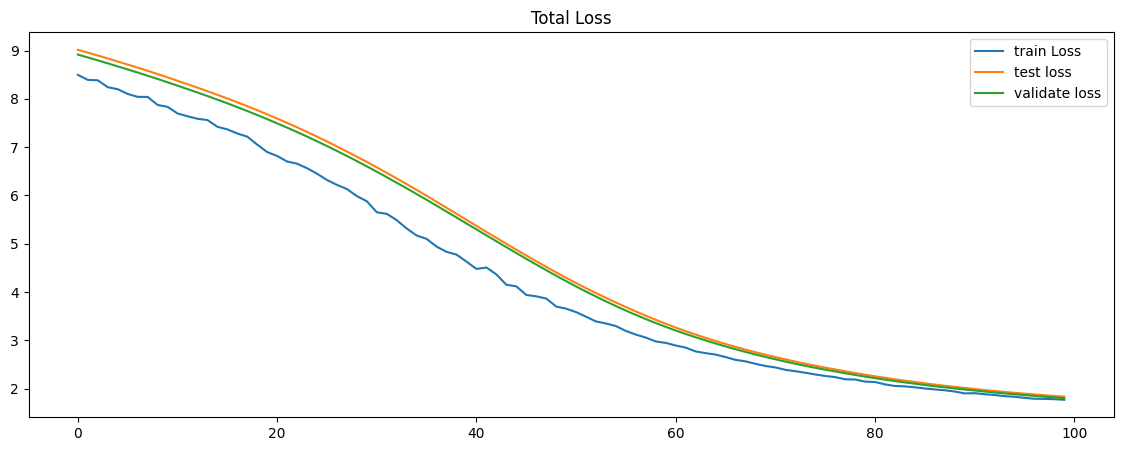

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(total_losses, label='train Loss')
plt.plot(test_total_losses, label='test loss')
plt.plot(val_total_losses, label='validate loss')
plt.legend()
plt.title('Total Loss')
plt.show()

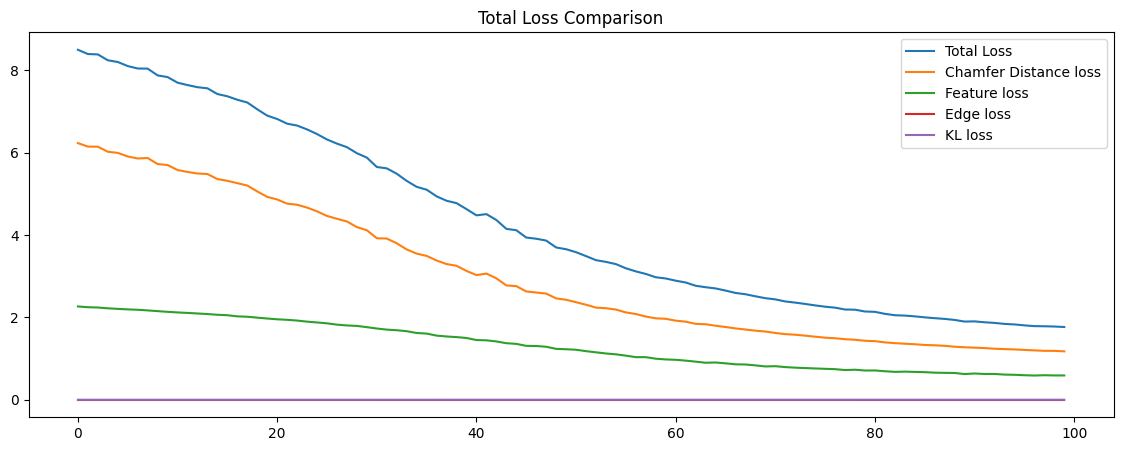

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(total_losses, label='Total Loss')
plt.plot(cd_losses, label='Chamfer Distance loss')
plt.plot(feature_losses, label='Feature loss')
plt.plot(edge_losses, label='Edge loss')
plt.plot(kl_losses, label='KL loss')
plt.legend()
plt.title('Total Loss Comparison')
plt.show()

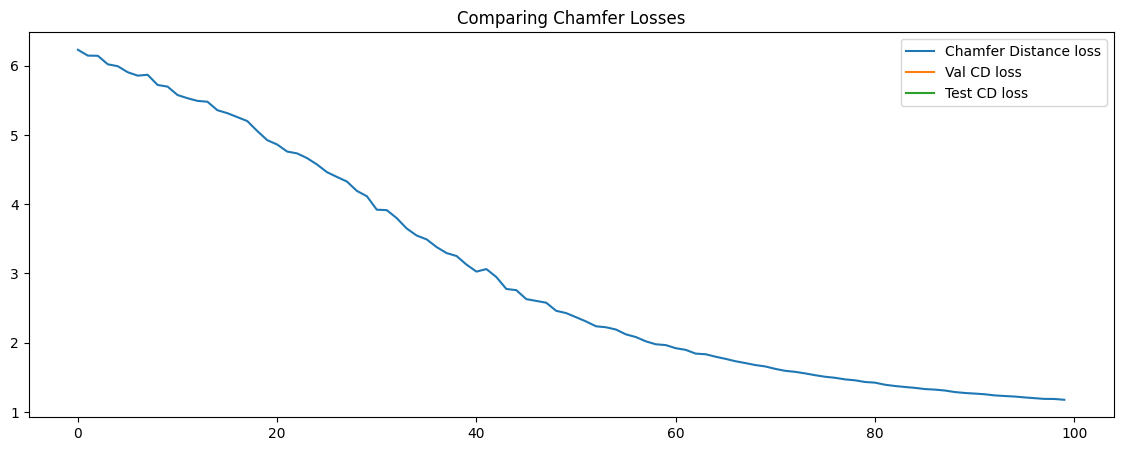

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(cd_losses, label='Chamfer Distance loss')
plt.plot(val_cd_loss, label='Val CD loss')
plt.plot(test_cd_loss, label='Test CD loss')
plt.legend()
plt.title('Comparing Chamfer Losses')
plt.show()

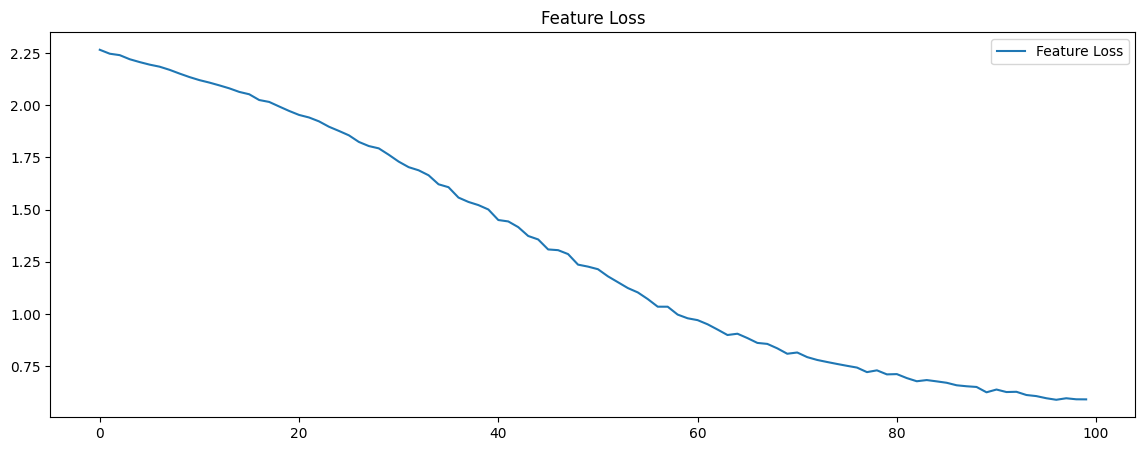

In [ ]:

plt.figure(figsize=(14, 5))
plt.plot(feature_losses, label='Feature Loss')
plt.legend()
plt.title('Feature Loss')
plt.show()